In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import  preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [22]:
def plot_acc(history, title="Model Accuracy", range=[0,1]):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.ylim(range[0], range[1])
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()

In [4]:
mainpath="../NSL-KDD/"
transformed_datasets_folder = "transformed_datasets/"
file_complete_traffic = "complete_traffic.csv"
csv_path = mainpath + transformed_datasets_folder + file_complete_traffic

In [5]:
df = pd.read_csv(csv_path)
df.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0.0,1,20,9,491.0,0.0,0,0.0,0.0,0.0,...,25.0,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0.0,2,44,9,146.0,0.0,0,0.0,0.0,0.0,...,1.0,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0.0,1,49,5,0.0,0.0,0,0.0,0.0,0.0,...,26.0,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0.0,1,24,9,232.0,8153.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0.0,1,24,9,199.0,420.0,0,0.0,0.0,0.0,...,255.0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [6]:
# Convert data frame into a numpy array and separate the features from the class column 
np_array = df.to_numpy()
class_label = np_array[:, -1] # for last column
data = np_array[:, :-1] # for all but last column

In [7]:
# Split the data for training, validation and testing: 70%, 20%, 10%
X_train, X_test, y_train, y_test = train_test_split(data, class_label, test_size=0.1, random_state=42)
print(len(data))
print(len(X_train))

148517
133665


In [8]:
# 0,9*0,23 = 0,207
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.23, random_state=42)
print(len(X_val))
print(len(X_train))

30743
102922


In [9]:
# One hot encoding 
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [10]:
# Normalize data 
X_train = preprocessing.normalize(X_train,norm='l2')
X_test = preprocessing.normalize(X_test,norm='l2')
X_val = preprocessing.normalize(X_val,norm='l2')

In [11]:
# Network Parameters
batch_size = 64
epochs = 50
hidden_units_1 = 16
hidden_units_2 = 8
hidden_units_3 = 8
hidden_units_4 = 64
num_labels = len(np.unique(y_train, return_counts=False))
input_size = data.shape[1]
activation_type = "relu"
kernel_init = "glorot_uniform"
patience = 5
regularization_parameter = 0.0001
dropout_parameter = 0.4


In [12]:
model = Sequential([
    Dense(hidden_units_1, input_dim=input_size, activation=activation_type, kernel_initializer=kernel_init,  
          kernel_regularizer=tf.keras.regularizers.l1(regularization_parameter)
      ),
    Dropout(dropout_parameter),
    Dense(hidden_units_2, activation=activation_type, kernel_initializer=kernel_init, 
          kernel_regularizer=tf.keras.regularizers.l1(regularization_parameter) 
    ),
    Dense(num_labels, activation='softmax')
])

In [13]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [14]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)

In [15]:
history = model.fit(X_train, y_train, 
              epochs=epochs, 
              validation_data=(X_val, y_val),
              batch_size=batch_size,
              callbacks=[es]
          )

Epoch 1/50
1609/1609 [==============================] - 22s 11ms/step - loss: 0.2893 - accuracy: 0.8868 - val_loss: 0.2008 - val_accuracy: 0.9286
Epoch 2/50
1609/1609 [==============================] - 17s 11ms/step - loss: 0.2123 - accuracy: 0.9147 - val_loss: 0.1726 - val_accuracy: 0.9361
Epoch 3/50
1609/1609 [==============================] - 18s 11ms/step - loss: 0.1932 - accuracy: 0.9236 - val_loss: 0.1599 - val_accuracy: 0.9407
Epoch 4/50
1609/1609 [==============================] - 16s 10ms/step - loss: 0.1839 - accuracy: 0.9281 - val_loss: 0.1513 - val_accuracy: 0.9391
Epoch 5/50
1609/1609 [==============================] - 18s 11ms/step - loss: 0.1751 - accuracy: 0.9323 - val_loss: 0.1433 - val_accuracy: 0.9473
Epoch 6/50
1609/1609 [==============================] - 16s 10ms/step - loss: 0.1699 - accuracy: 0.9350 - val_loss: 0.1389 - val_accuracy: 0.9498
Epoch 7/50
1609/1609 [==============================] - 17s 10ms/step - loss: 0.1656 - accuracy: 0.9369 - val_loss: 0.1347 -

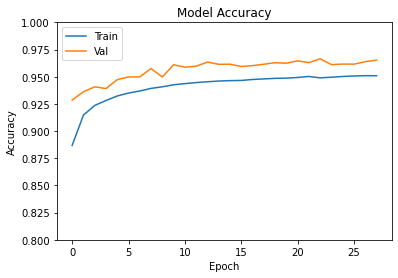

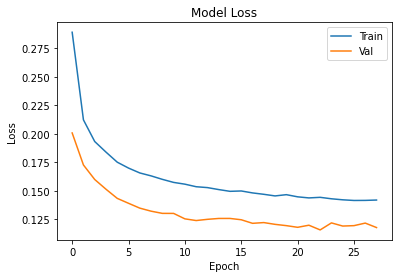

In [25]:
plot_acc(history, range=[0.8,1])
plot_loss(history)

In [17]:
y_test_cat = to_categorical(y_test)
_, acc = model.evaluate(X_test, y_test_cat, batch_size=batch_size)
print("Accuracy Test sample: %.1f%%" % (100.0 * acc))

233/233 [==============================] - 1s 6ms/step - loss: 0.1222 - accuracy: 0.9609
Accuracy Test sample: 96.1%


In [18]:
# predict classes for test set
y_predicted_classes = np.argmax(model.predict(X_test), axis=-1)

In [19]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_predicted_classes)
print("Accuracy Test sample: %.1f%%" % (100.0 * accuracy))

# precision tp / (tp + fp)
precision = precision_score(y_test, y_predicted_classes)
print("Precision Test sample: %.1f%%" % (100.0 * precision))

# recall: tp / (tp + fn)
recall = recall_score(y_test, y_predicted_classes)
print("Recall Test sample: %.1f%%" % (100.0 * recall))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_predicted_classes)
print("F1 score Test sample: %.1f%%" % (100.0 * f1))

Accuracy Test sample: 96.1%
Precision Test sample: 95.9%
Recall Test sample: 95.9%
F1 score Test sample: 95.9%
